# A comparison of covariance functions used to inference the rotation periods of stars using [celerite](https://github.com/dfm/celerite) model

Based on the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) from Foreman-Mackey ([2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract)). Written by [Pavel Sobolev](https://github.com/Paveloom) and located [here](https://github.com/Paveloom/C2).

Importing standard packages and modules:

In [1]:
import copy # Copying
from matplotlib import rcParams as rcp, pyplot as plt # Plots

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr), [corner](https://github.com/dfm/corner.py), [emcee](https://github.com/dfm/emcee) and [celerite](https://github.com/dfm/celerite) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[optimization](https://github.com/scipy/scipy/tree/master/scipy/optimize) module from [scipy](https://github.com/scipy/scipy) developed by contributors.

In [2]:
import kplr # Tools for working with Kepler data
import corner # Tools for making corner plots
import emcee # The Python ensemble sampling toolkit for affine-invariant MCMC
from celerite import plot_setup, terms # Scalable 1D Gaussian Processes

from autograd import numpy as np # Derivatives of numpy code
from scipy.optimize import minimize # Minimization of a scalar function

Setting plots parameters:

In [3]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting DPIs of figures
rcp["savefig.dpi"] = 300
rcp["figure.dpi"]  = 300

# Setting other plots settings
plot_setup.setup(auto=False)

Loading sample data from [KIC](https://archive.stsci.edu/kepler/kic.html) (field descriptors are taken from [Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)):

In [4]:
# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attaching the kplr API
client = kplr.API()

# Getting the star data
star = client.star(KIC_ID)

# Time
t = []

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux
f = []

# The 1-sigma error in PDC flux values
ferr = []

# Getting short cadence light curves
for lc in star.get_light_curves(short_cadence=False):
    
    # Reading data from a light curve
    data = lc.read()
    
    # Getting time values from the data
    t0 = data["TIME"]
    
    # Getting PDCSAP flux values from the data
    f0 = data["PDCSAP_FLUX"]
    
    # Creating a mask for only qualitative data points
    mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)

    # Appending the qualitative time data to the existing list
    t.append(t0[mask])
    
    # Computing the median of the flux data
    mu = np.median(f0[mask])
    
    # Scaling the qualitative flux data and appending it to the existing list
    f.append( ( f0[mask] / mu - 1.0 ) * 1e3 )
    
    # Scaling the qualitative flux error data and appending it to the existing list
    ferr.append( data["PDCSAP_FLUX_ERR"][mask] / mu * 1e3 )
    
# Concatenating arrays

t = np.concatenate(t)
f = np.concatenate(f)
ferr = np.concatenate(ferr)

# Getting the indices that would sort an array
inds = np.argsort(t)

# Getting contiguous arrays

t = np.ascontiguousarray(t[inds], dtype = float)
f = np.ascontiguousarray(f[inds], dtype = float)
ferr = np.ascontiguousarray(ferr[inds], dtype = float)

Plotting the input data (error bars are ommited)

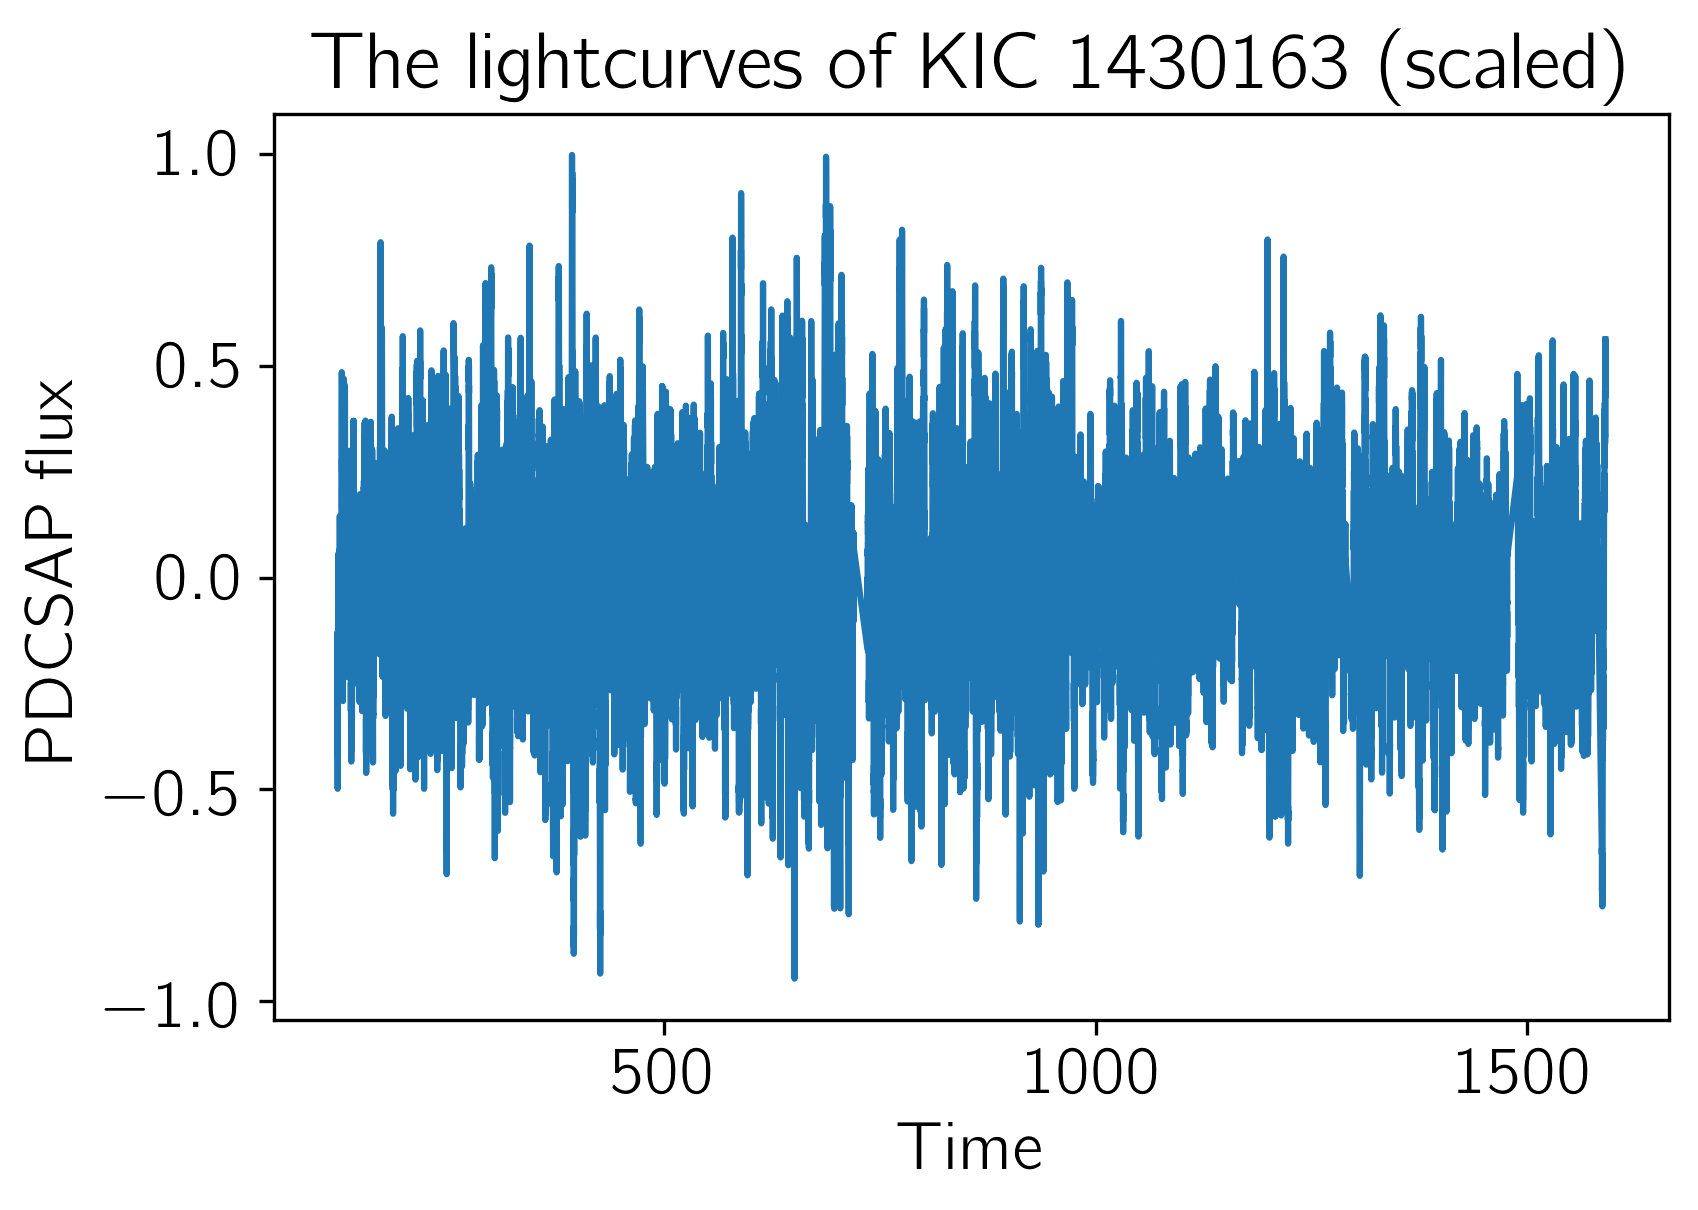

In [5]:
plt.plot(t, f) # Plotting the data
plt.title("The lightcurves of KIC 1430163 (scaled)") # Setting a title
plt.xlabel("Time") # Setting the x-axis label
plt.ylabel("PDCSAP flux") # Setting the y-axis label
plt.savefig("figures/input.png", bbox_inches = "tight") # Saving the figure